In [ ]:
!pip3 install tensorflow_decision_forests scikit-learn imbalanced-learn --upgrade
!pip install xgboost catboost

<img src="https://i.ibb.co/6rNTPrM/Whats-App-Image-2021-06-05-at-11-18-49.jpg" alt="Whats-App-Image-2021-06-05-at-11-18-49">

**Problem Statement:** 
The presentation makes a predictive model to predict the rainfall for the next day in Australia, if it is going to rain or not, through a binary outcome in a trained model.

**About data:**
The dataset contains about 10 years of daily weather observations from many locations across Australia.

"RainTomorrow" is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

**Dataset: Features & Description**

| Features| Description|
----------|:------------
|Date| The date of Observation|
|Location|	The common name of the location of the weather station|
MinTemp|	The minimum temperature in degrees celsius|
|MaxTemp|	The maximum temperature in degrees celsius|
|Rainfall|	The amount of rainfall recorded for the day in mm|
|Evaporation|	The so-called Class A pan evaporation (mm) in the 24 hours to 9am|
|Sunshine|	The number of hours of bright sunshine in the day.|
|WindGustDir|	The direction of the strongest wind gust in the 24 hours to midnight|
|WindGustSpeed|	The speed (km/h) of the strongest wind gust in the 24 hours to midnight|
|WindDir9am|	Direction of the wind at 9am|
|WindDir3pm|	Direction of the wind at 3pm|
|WindSpeed9am|	Wind speed (km/hr) averaged over 10 minutes prior to 9am|
|WindSpeed3pm|	Wind speed (km/hr) averaged over 10 minutes prior to 3pm|
|Humidity9am|	Humidity (percent) at 9am|
|Humidity3pm|	Humidity (percent) at 3pm|
|Pressure9am|	Atmospheric pressure (hpa) reduced to mean sea level at 9am|
|Pressure3pm|	Atmospheric pressure (hpa) reduced to mean sea level at 3pm|
|Cloud9am|	Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.|
|Cloud3pm|	Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm.|Cload9am| for a description of the values|
|Temp9am|	Temperature (degrees C) at 9am|
|Temp3pm|	Temperature (degrees C) at 3pm|
|RainToday|	Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0|
|RainTomorrow|	The amount of next day rain in mm. Used to create response| variable RainTomorrow. A kind of measure of the "risk".|


**Importing the required libraries**

In [ ]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, cohen_kappa_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV, RFE

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, BaggingClassifier

from sklearn.base import clone
from sklearn.model_selection import train_test_split
import missingno as msno
import scipy.stats as st

from sklearn import set_config
import xgboost as xgb
import catboost as cb
import keras
import tensorflow_decision_forests as tfdf

sns.set(rc={'figure.figsize':(11.7,8.27)})

set_config(display='diagram')

**Reading the Dataset**

Load the CSV file

In [ ]:
df = pd.read_csv('./dataset.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


checking the size of data

In [ ]:
df.shape

(145460, 23)

Checking data types of variables

In [ ]:
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

**Data Preparation**

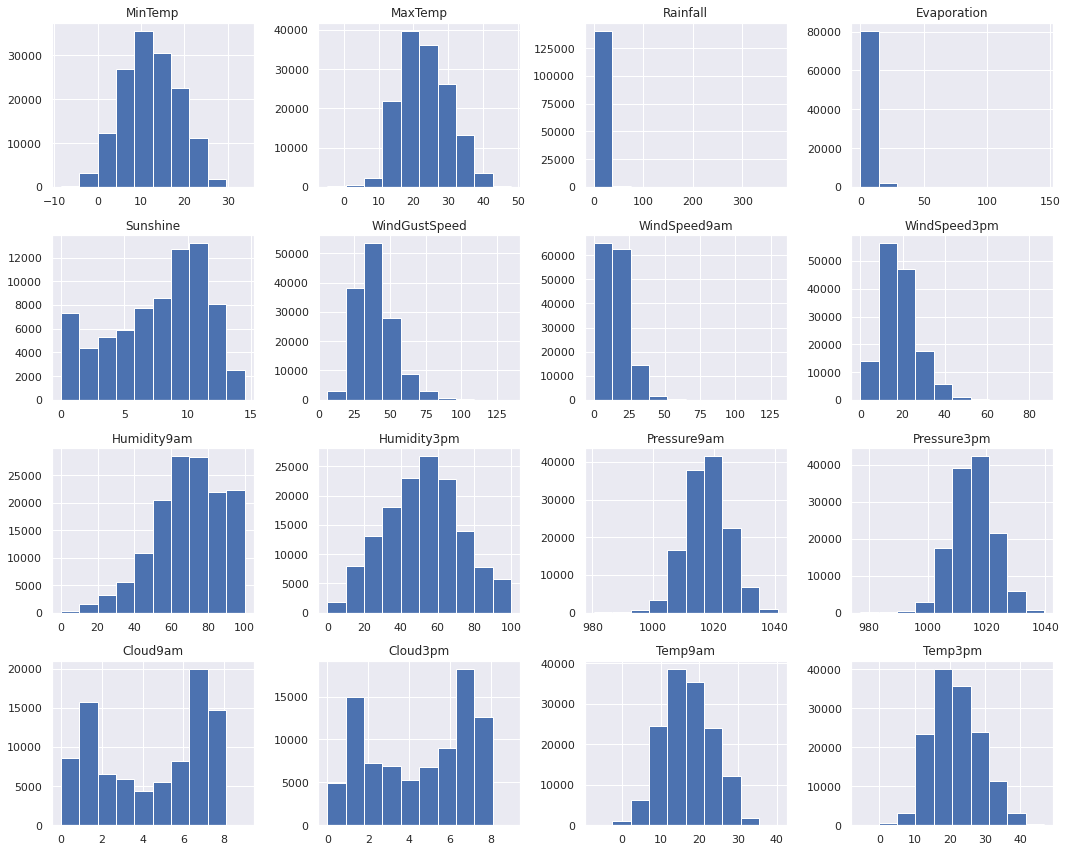

In [ ]:
plt.rcParams['figure.figsize']=[15,12]
df_features=df.drop('RainTomorrow', axis = 1)
df_features.hist()
plt.tight_layout()
plt.show()

**Observation:** From the above plot, we infer that MinTemp, MaxTemp, Humidity3PM, Pressure9AM, Pressure3PM, Temp9AM, Tempe3PM are normally distributed.

In [ ]:
df['Date'].isnull().sum()

0

Converting Date to Month

In [ ]:
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Month'].value_counts().sort_index()

1     13236
2     10793
3     13361
4     11550
5     13353
6     12684
7     12025
8     12028
9     11640
10    12028
11    11669
12    11093
Name: Month, dtype: int64

Merging similar locations

In [ ]:
df['Location'].isnull().sum()

0

In [ ]:
df['Location'].value_counts().sort_index()

Adelaide            3193
Albany              3040
Albury              3040
AliceSprings        3040
BadgerysCreek       3009
Ballarat            3040
Bendigo             3040
Brisbane            3193
Cairns              3040
Canberra            3436
Cobar               3009
CoffsHarbour        3009
Dartmoor            3009
Darwin              3193
GoldCoast           3040
Hobart              3193
Katherine           1578
Launceston          3040
Melbourne           3193
MelbourneAirport    3009
Mildura             3009
Moree               3009
MountGambier        3040
MountGinini         3040
Newcastle           3039
Nhil                1578
NorahHead           3004
NorfolkIsland       3009
Nuriootpa           3009
PearceRAAF          3009
Penrith             3039
Perth               3193
PerthAirport        3009
Portland            3009
Richmond            3009
Sale                3009
SalmonGums          3001
Sydney              3344
SydneyAirport       3009
Townsville          3040


In [ ]:
df['Location'].replace({'MelbourneAirport':'Melbourne','PerthAirport':'Perth','SydneyAirport':'Sydney'}, inplace=True)

In [ ]:
locations = df['Location'].value_counts()

Locations : 46


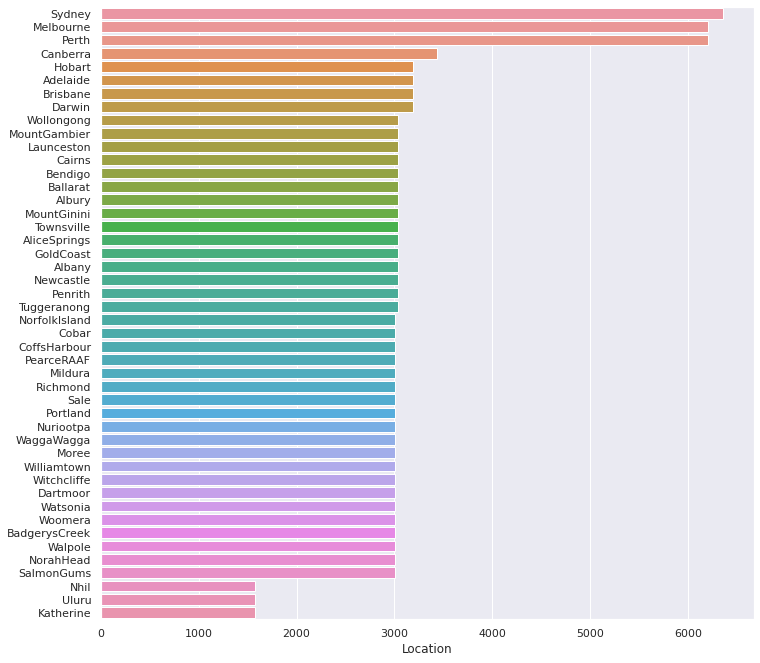

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(11.7,11.27))
sns.barplot(x=locations, y=locations.index, ax=ax)
print('Locations : {}'.format(locations.shape[0]))

**Handling Numeric Variables:**

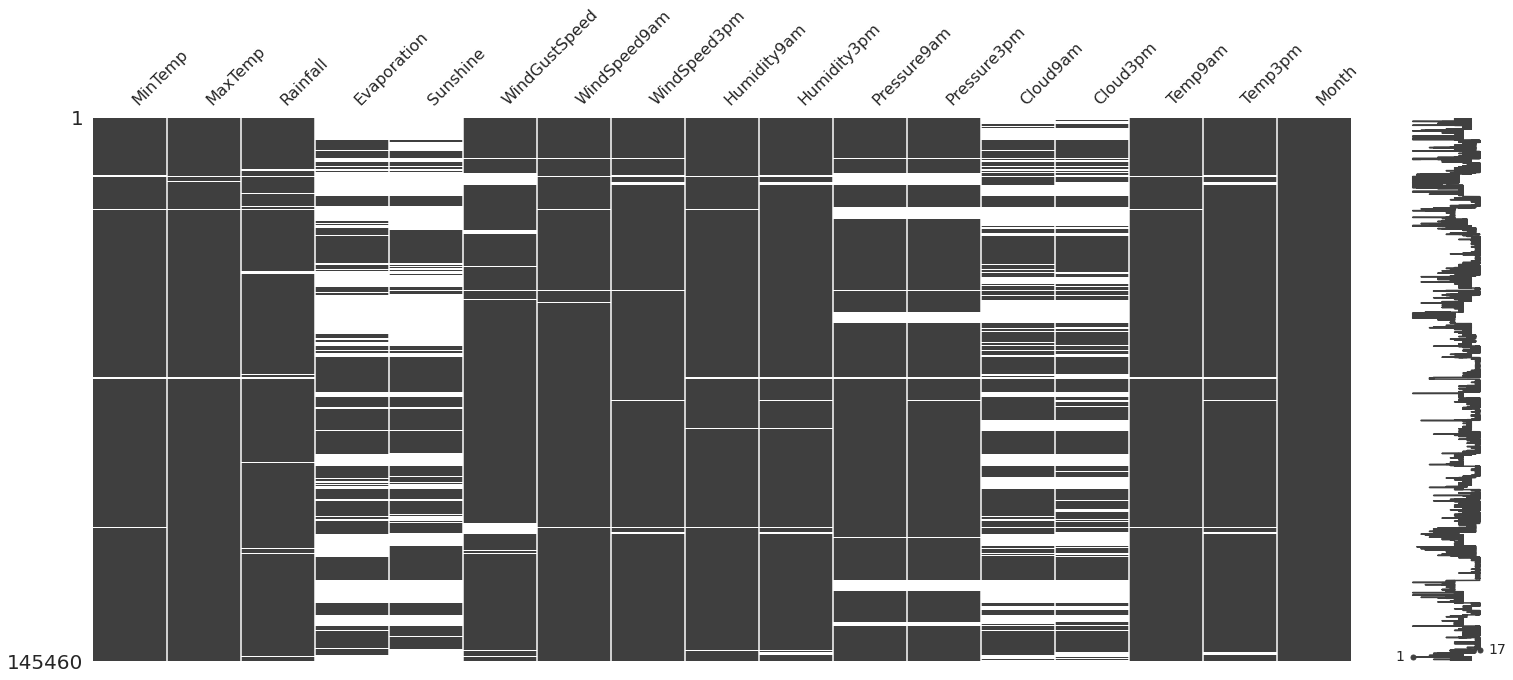

In [ ]:
msno.matrix(df._get_numeric_data())

In [ ]:
(df.isnull().sum()/len(df))*100


Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
Month             0.000000
dtype: float64

Observation : Features such as 'Evaporation','Sunshine','Cloud9am','Cloud3pm' have maximum null values





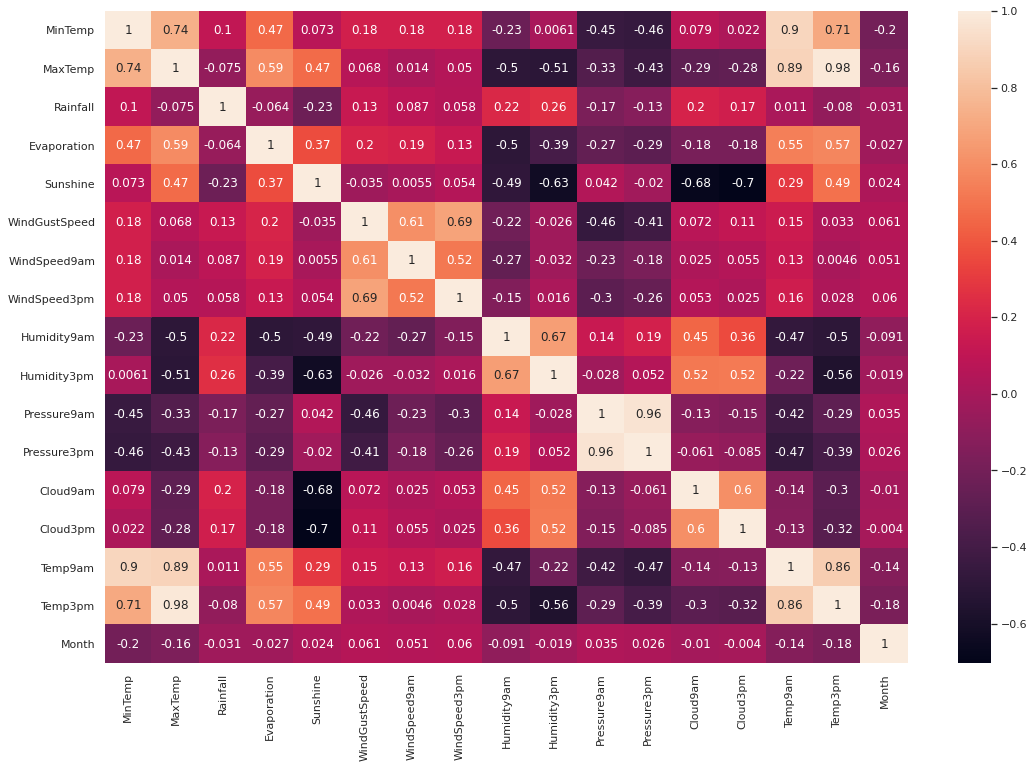

In [ ]:
_, ax = plt.subplots(1,1, figsize=(18,12))
sns.heatmap(df.corr(), annot=True, )
plt.show()

Drop Temp9am, Temp3pm since it has high correlation with MinTemp and MaxTemp

* Drop Temp9am, Temp3pm since it has high correlation with MinTemp and MaxTemp.
* Drop WindDir9am, WindDir3pm, WindSpeed3pm, WindSpeed9am since it has high correlation with WindGustDir and WindGustSpeed.
* Drop Evaporation, Sunshine, Cloud9am, Cloud3pm since it has high correlation with himidity and more missing values. 
* Drop Date column, we have converted it to month


In [ ]:
df.drop(columns=['Temp9am','Temp3pm','WindDir9am','WindDir3pm','WindSpeed3pm','WindSpeed9am','Evaporation',
                'Sunshine','Cloud9am','Cloud3pm','Date'], inplace=True)
print('')

In [ ]:
df.head(3)

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow,Month
0,Albury,13.4,22.9,0.6,W,44.0,71.0,22.0,1007.7,1007.1,No,No,12
1,Albury,7.4,25.1,0.0,WNW,44.0,44.0,25.0,1010.6,1007.8,No,No,12
2,Albury,12.9,25.7,0.0,WSW,46.0,38.0,30.0,1007.6,1008.7,No,No,12


In [ ]:
df['RainTomorrow'].isnull().sum()

3267

Considering the Target Variable

In [ ]:
df.dropna(subset=['RainTomorrow'], inplace=True)

In [ ]:
df.shape

(142193, 13)

In [ ]:
df['RainTomorrow'].replace({'Yes':1,'No':0}, inplace=True)

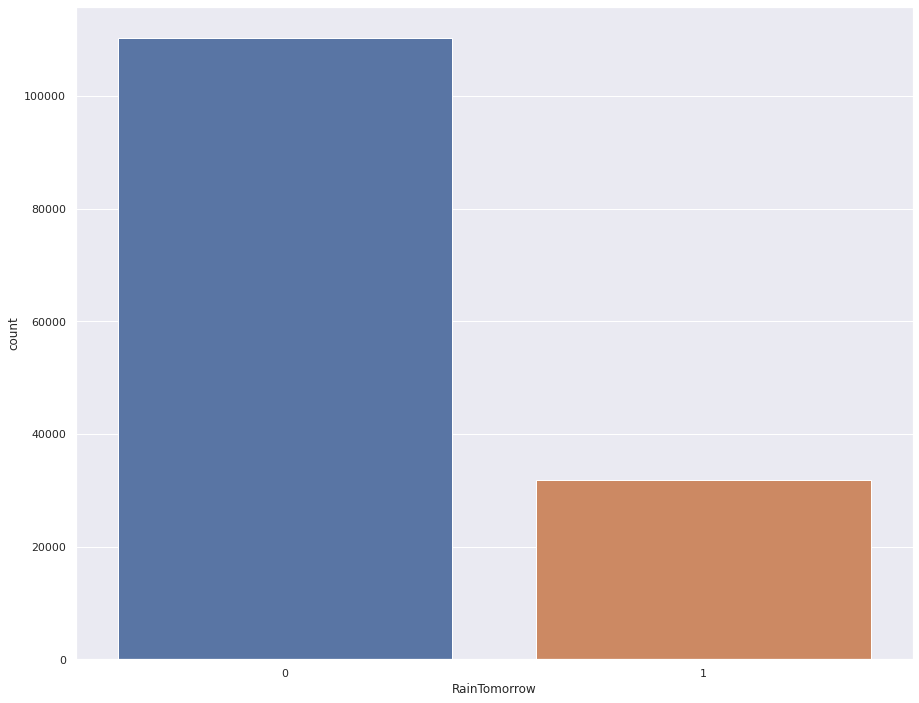

In [ ]:
sns.countplot(x = df['RainTomorrow'])

In [ ]:
df['RainTomorrow'].value_counts()

0    110316
1     31877
Name: RainTomorrow, dtype: int64

In [ ]:
df_num=df.select_dtypes(include='number')
df_num.head(2)

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainTomorrow,Month
0,13.4,22.9,0.6,44.0,71.0,22.0,1007.7,1007.1,0,12
1,7.4,25.1,0.0,44.0,44.0,25.0,1010.6,1007.8,0,12


**Outlier Analysis and Treatment**

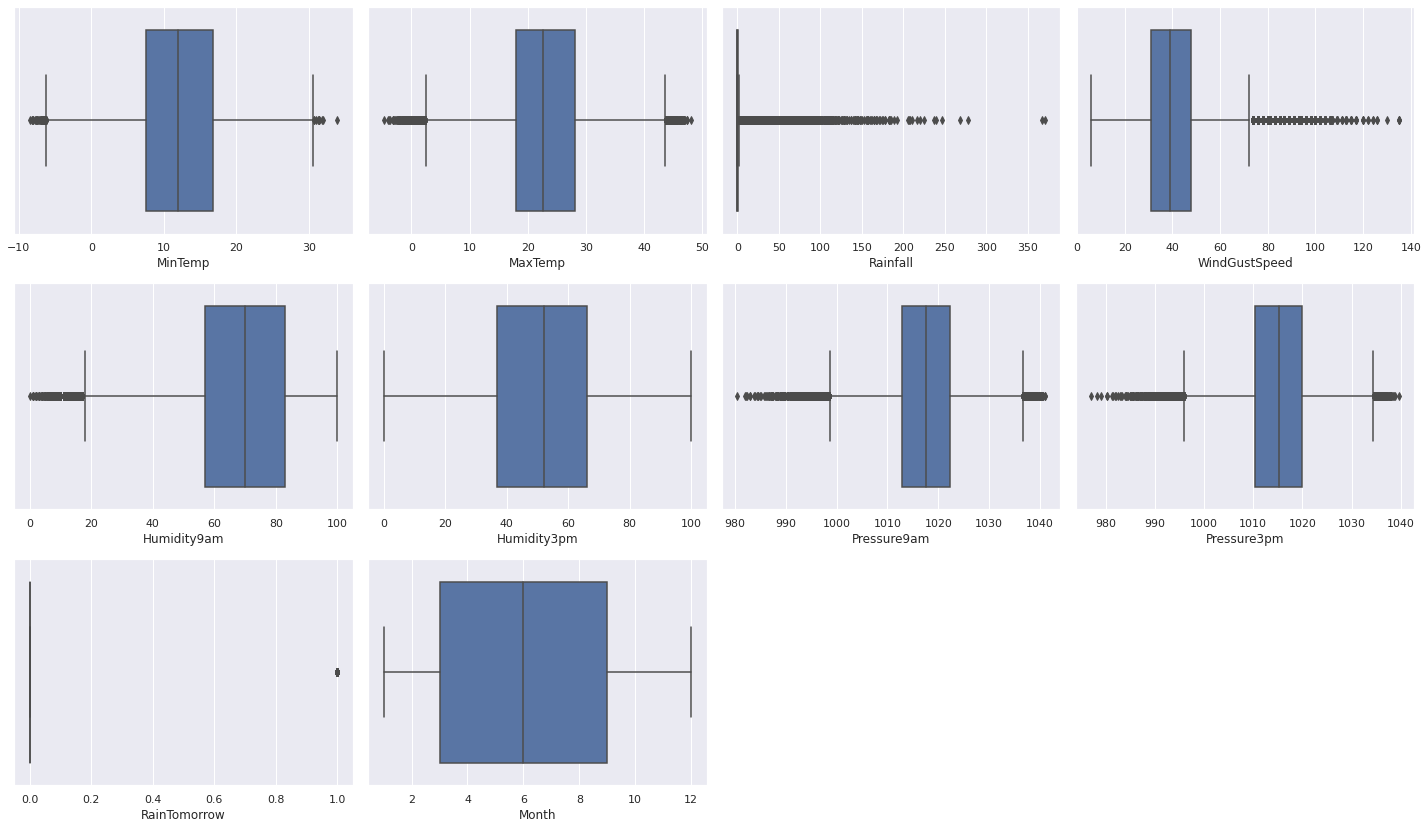

In [ ]:

plt.figure(figsize=(20,15))
j=1
for i in df_num.columns:
    plt.subplot(4,4,j)
    sns.boxplot(x=df_num[i])
    j=j+1
    plt.tight_layout()


**Observation** : From Boxplot of different features, we interpret that rainfall has maximum outliers and hence we are performing outlier treatment using capping/ winsorization.

In [ ]:
df['Rainfall'].describe()

count    140787.000000
mean          2.349974
std           8.465173
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max         371.000000
Name: Rainfall, dtype: float64

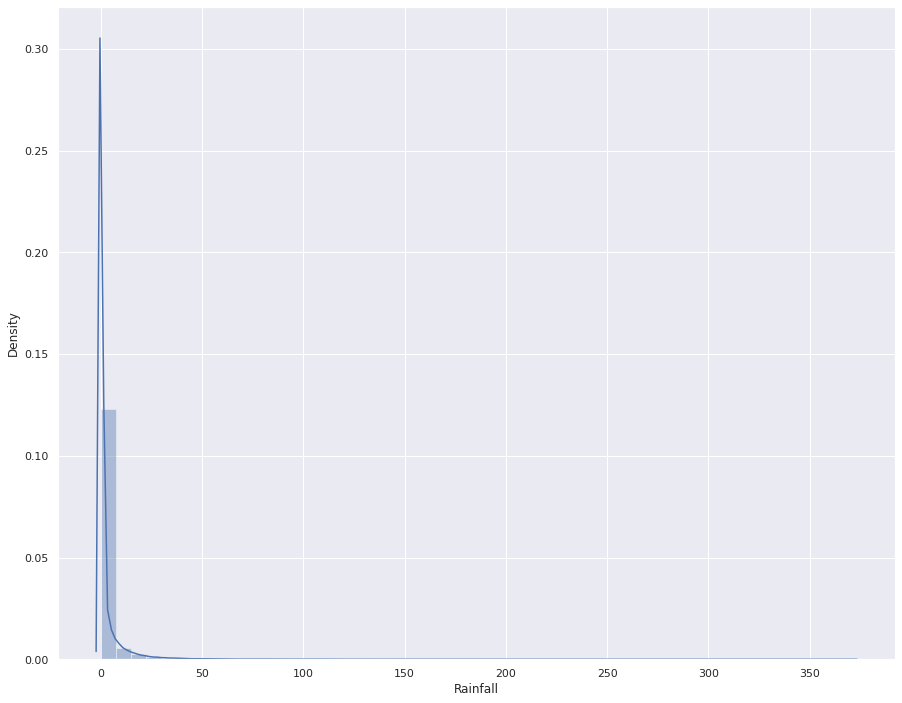

In [ ]:
sns.distplot(df['Rainfall'])

In [ ]:
df['Rainfall'].clip(upper=df['Rainfall'].quantile(0.99), lower=df['Rainfall'].quantile(0.01), inplace=True)

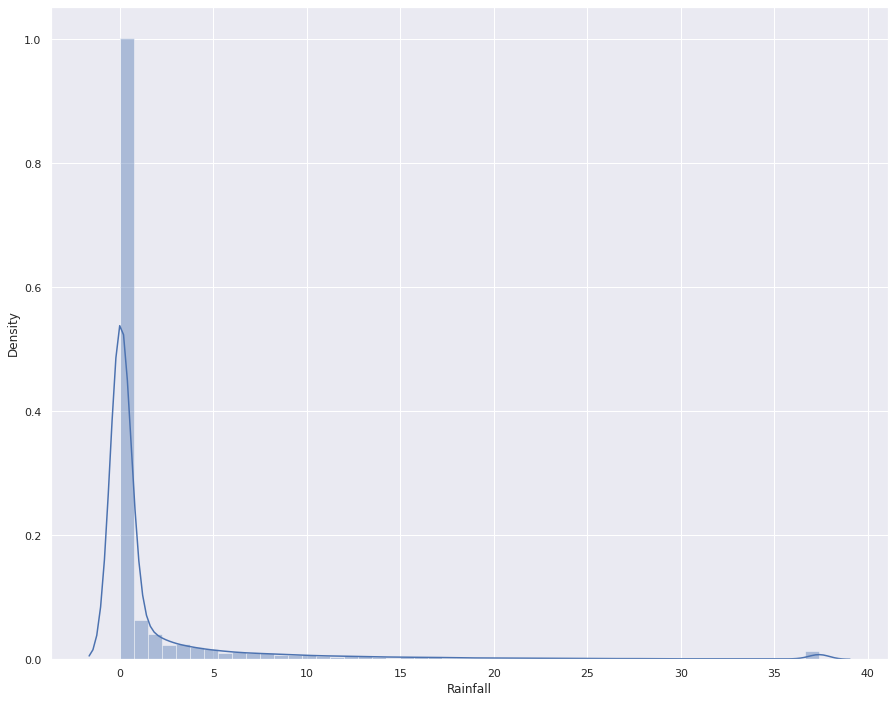

In [ ]:
sns.distplot(df['Rainfall'])

Segregating target and independent variables

In [ ]:
y = df['RainTomorrow']
X = df.drop(columns=['RainTomorrow'])

Segregating numerical and categorical columns

In [ ]:
numerical = ['MinTemp','MaxTemp','Rainfall','WindGustSpeed','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm']
categorical = ['Location','RainToday','Month','WindGustDir']

**Model Building:**

In [ ]:
transform1 = make_pipeline(
  make_column_transformer(
    (
      make_pipeline(
        IterativeImputer(random_state=42),
        StandardScaler()
      ),
      numerical
    ),
    (
      make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(sparse=False, drop='first'),
      ),
      categorical
    )
  )
)
transform1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer(random_state=42)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'WindGustSpeed',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am',
                                                   'Pressure3pm']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Location', 'RainToday',
                                                   'Month',
                                                   'WindGustDir'])]))])

Train and Test Split

In [ ]:
X1 = transform1.fit_transform(X,y)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y, random_state=42, stratify=y, test_size=0.3) 

**Model 1:** Logistic Regrssion

In [ ]:
model1 = LogisticRegression()
model1.fit(X_train1, y_train1)

LogisticRegression()

In [ ]:
def print_model(model, X_t,y_t):
  ypred = model.predict(X_t)
  print(classification_report(y_t, ypred))
  print('cohen kappa score {}'.format(cohen_kappa_score(y_t, ypred)))
  _, axes = plt.subplots(1,3, figsize=(24,6))
  plot_confusion_matrix(model, X_t, y_t, ax=axes[0])
  plot_roc_curve(model, X_t, y_t, ax=axes[1], name='roc curve')
  plot_precision_recall_curve(model, X_t, y_t, ax=axes[2], name='precision recall curve')

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     33095
           1       0.73      0.50      0.59      9563

    accuracy                           0.85     42658
   macro avg       0.80      0.72      0.75     42658
weighted avg       0.84      0.85      0.84     42658

cohen kappa score 0.5041529202914216


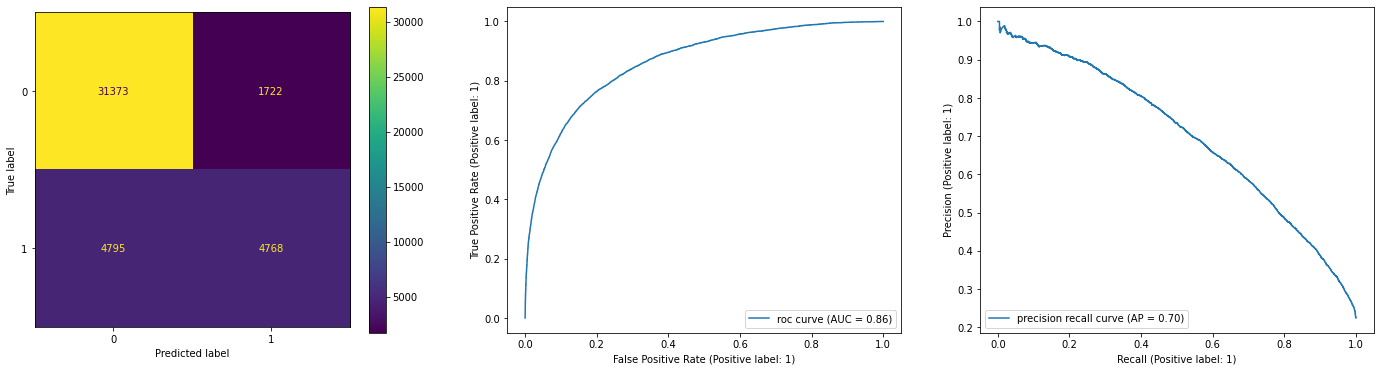

In [ ]:
print_model(model1, X_test1, y_test1)

**Model 2:** K-Nearest Neighbour

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     33095
           1       0.70      0.49      0.58      9563

    accuracy                           0.84     42658
   macro avg       0.78      0.72      0.74     42658
weighted avg       0.83      0.84      0.83     42658

cohen kappa score 0.4814657237448081


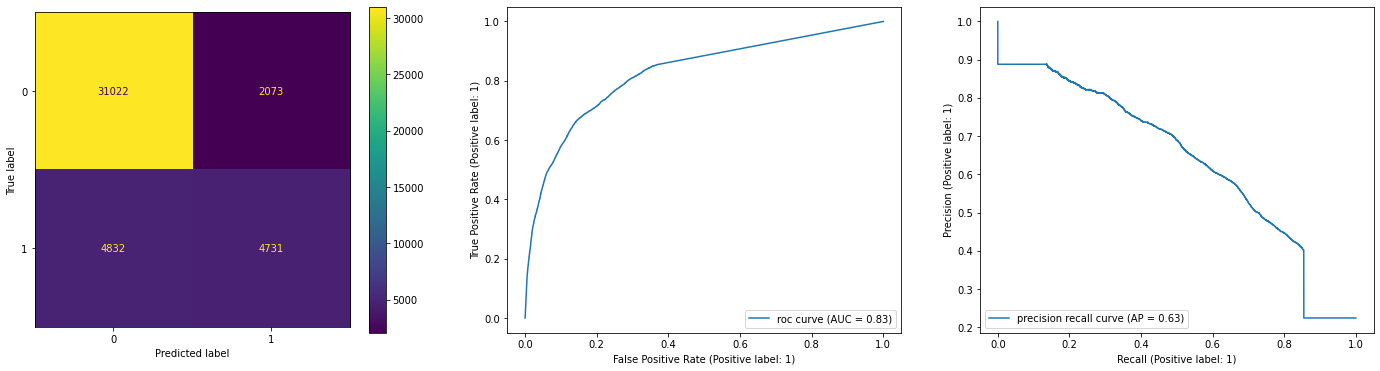

In [ ]:
model2 = KNeighborsClassifier(n_jobs=-1, n_neighbors=5, weights='distance')
model2.fit(X_train1, y_train1)
print_model(model2, X_test1, y_test1)

**Model 3:** Decision Tree 

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     33095
           1       0.74      0.43      0.54      9563

    accuracy                           0.84     42658
   macro avg       0.80      0.69      0.72     42658
weighted avg       0.83      0.84      0.82     42658

cohen kappa score 0.45091452281031763


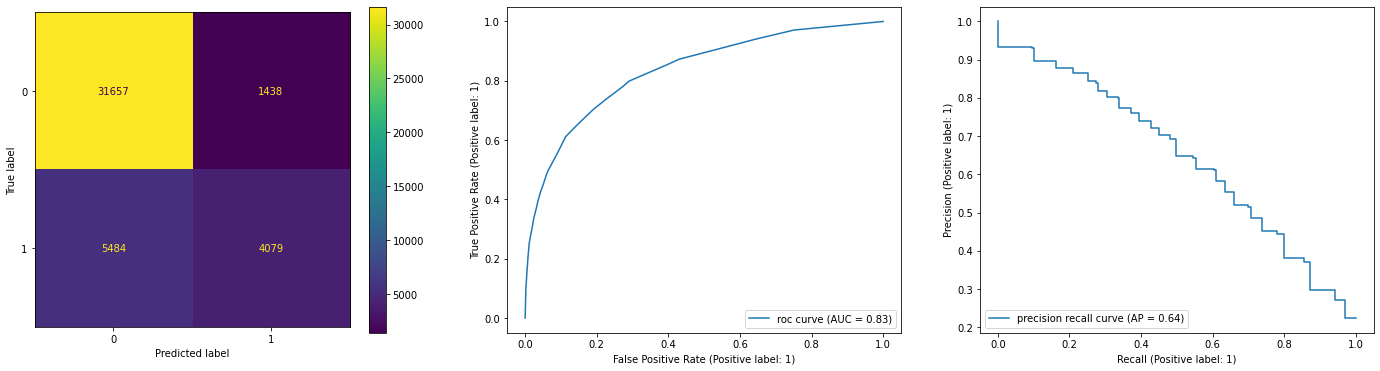

In [ ]:
model4 = DecisionTreeClassifier(max_depth=5, random_state=42)
model4.fit(X_train1, y_train1)
print_model(model4, X_test1, y_test1)

**Model 5:** Random Forest 

              precision    recall  f1-score   support

           0       0.85      0.97      0.90     33095
           1       0.80      0.38      0.52      9563

    accuracy                           0.84     42658
   macro avg       0.82      0.68      0.71     42658
weighted avg       0.83      0.84      0.82     42658

cohen kappa score 0.4360223920623527


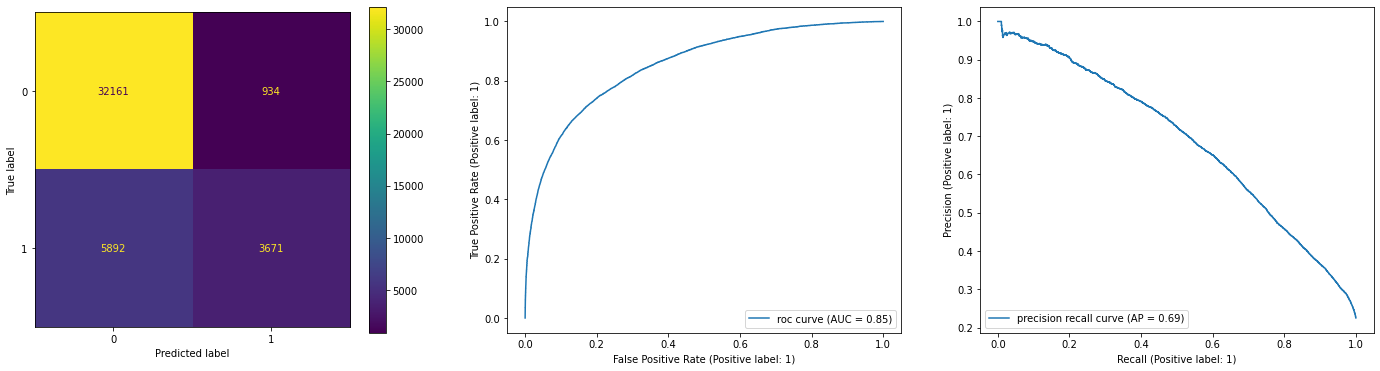

In [ ]:
model5 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model5.fit(X_train1, y_train1)
print_model(model5, X_test1, y_test1)

**Model 6:** AdaBoost Classifier

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     33095
           1       0.73      0.50      0.59      9563

    accuracy                           0.85     42658
   macro avg       0.80      0.72      0.75     42658
weighted avg       0.84      0.85      0.83     42658

cohen kappa score 0.4998343919967969


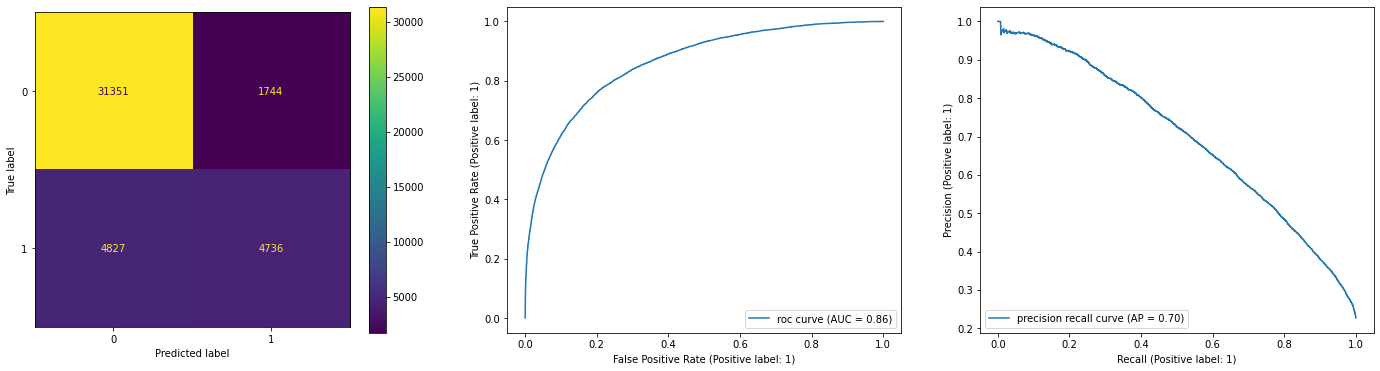

In [ ]:
model6 = AdaBoostClassifier(random_state=42, n_estimators=100)
model6.fit(X_train1, y_train1)
print_model(model6, X_test1, y_test1)

**Model 7:** Gradient Boosting

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     33095
           1       0.75      0.49      0.59      9563

    accuracy                           0.85     42658
   macro avg       0.81      0.72      0.75     42658
weighted avg       0.84      0.85      0.84     42658

cohen kappa score 0.5056611902039383


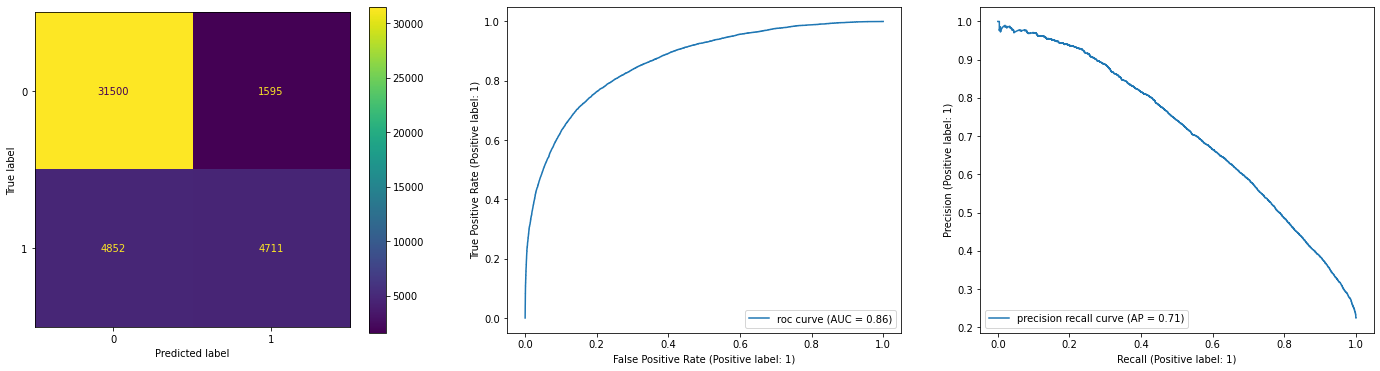

In [ ]:
model7 = GradientBoostingClassifier(random_state=42, n_estimators=100)
model7.fit(X_train1, y_train1)
print_model(model7, X_test1, y_test1)

**Model 7 / 8:** Voting Classifier

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     33095
           1       0.77      0.49      0.60      9563

    accuracy                           0.85     42658
   macro avg       0.82      0.72      0.75     42658
weighted avg       0.84      0.85      0.84     42658

cohen kappa score 0.5143016289766877


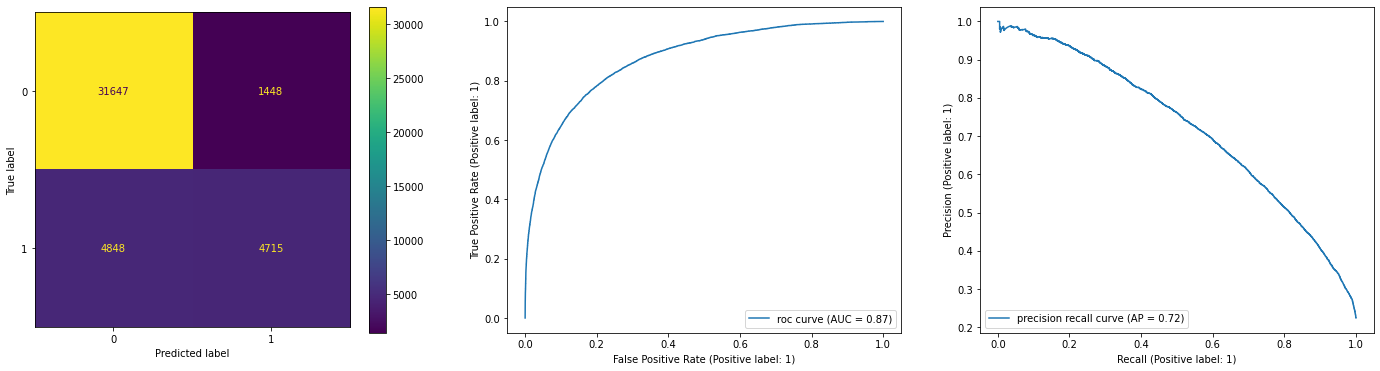

In [ ]:
model7 = VotingClassifier(estimators=[
    ('tree1', DecisionTreeClassifier(max_depth=10, random_state=42, criterion='gini')),
    ('tree2', DecisionTreeClassifier(max_depth=10, random_state=42, criterion='entropy')),
    ('forest1', RandomForestClassifier(max_depth=15, n_estimators=100, random_state=42, n_jobs=-1)),
    ('ada1', AdaBoostClassifier(random_state=42, n_estimators=100)),
    ('gb1', GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=10))                               
], n_jobs=-1, voting='soft')
model7.fit(X_train1, y_train1)
print_model(model7, X_test1, y_test1)

In [ ]:
underSampler = RandomUnderSampler(random_state=42, sampling_strategy=0.5)

In [ ]:
X3,y3 = underSampler.fit_resample(X1, y)

In [ ]:
X3.shape

(95631, 80)

In [ ]:
pd.Series(y3).value_counts()

0    63754
1    31877
Name: RainTomorrow, dtype: int64

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3, random_state=42, stratify=y3, test_size=0.3) 

              precision    recall  f1-score   support

           0       0.83      0.91      0.86     19127
           1       0.77      0.62      0.68      9563

    accuracy                           0.81     28690
   macro avg       0.80      0.76      0.77     28690
weighted avg       0.81      0.81      0.80     28690

cohen kappa score 0.5514269674666936


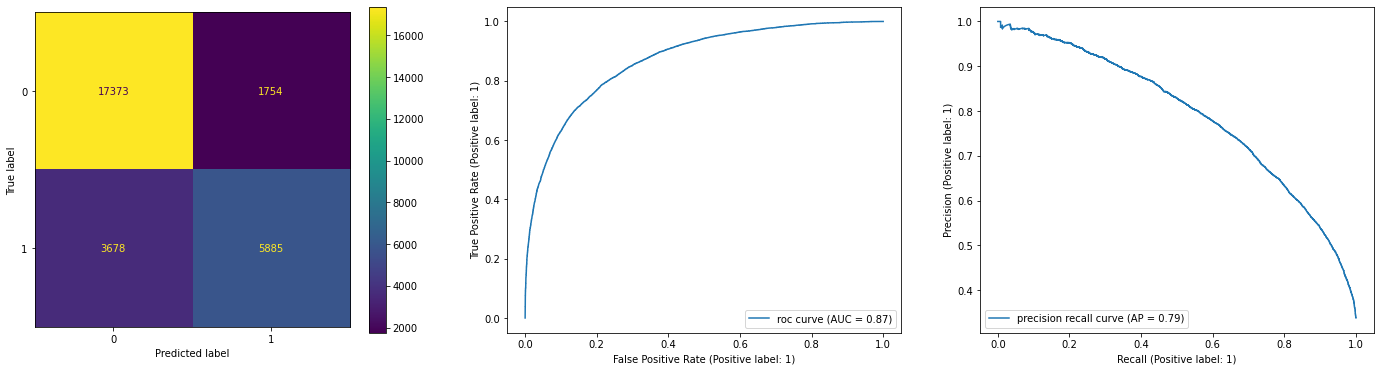

In [ ]:
model8 = VotingClassifier(estimators=[
    ('tree1', DecisionTreeClassifier(max_depth=10, random_state=42, criterion='gini')),
    ('tree2', DecisionTreeClassifier(max_depth=10, random_state=42, criterion='entropy')),
    ('forest1', RandomForestClassifier(max_depth=15, n_estimators=100, random_state=42, n_jobs=-1)),
    ('ada1', AdaBoostClassifier(random_state=42, n_estimators=100)),
    ('gb1', GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=10))                               
], n_jobs=-1, voting='soft')
model8.fit(X_train3, y_train3)
print_model(model8, X_test3, y_test3)

In [ ]:
import tensorflow_decision_forests as tfdf

**Model 9:** Bagging Classifier

In [ ]:
model9 = BaggingClassifier(LogisticRegression(), n_estimators=20, n_jobs=-1, random_state=42, verbose=4)
model9.fit(X_train3, y_train3)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   31.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   31.1s finished


BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=20,
                  n_jobs=-1, random_state=42, verbose=4)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished


              precision    recall  f1-score   support

           0       0.82      0.90      0.86     19127
           1       0.75      0.61      0.68      9563

    accuracy                           0.80     28690
   macro avg       0.79      0.76      0.77     28690
weighted avg       0.80      0.80      0.80     28690

cohen kappa score 0.5379307307764579


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished


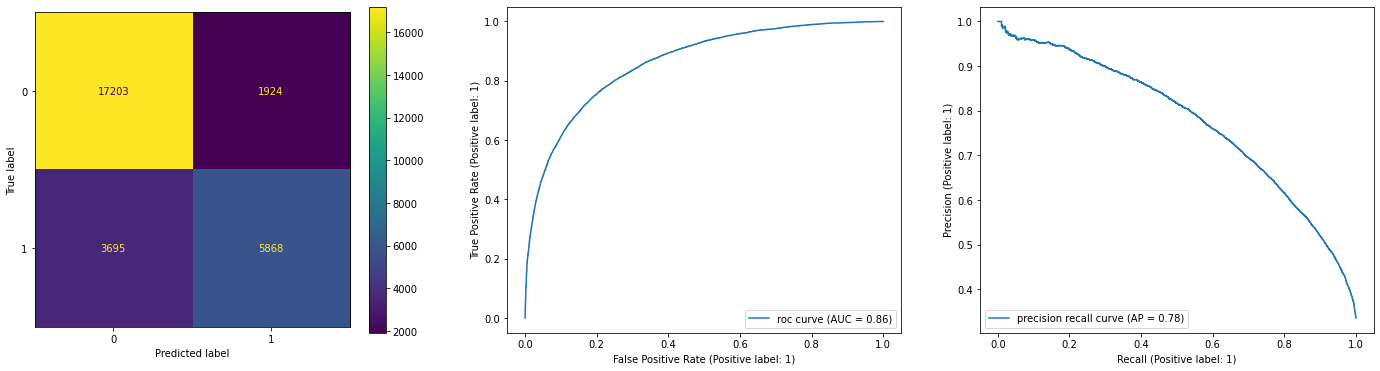

In [ ]:
print_model(model9, X_test3, y_test3)

**Model 10:** Grid search 

In [ ]:
model10 = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid={
   'max_depth':np.arange(5,20,5),
   'n_estimators': [100,150,200] 
}, verbose=1, n_jobs=-1, scoring='f1', cv=5);
model10.fit(X_train3, y_train3)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': array([ 5, 10, 15]),
                         'n_estimators': [100, 150, 200]},
             scoring='f1', verbose=1)

In [ ]:
model10.best_estimator_

RandomForestClassifier(max_depth=15, n_estimators=150, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     19127
           1       0.77      0.59      0.67      9563

    accuracy                           0.81     28690
   macro avg       0.80      0.75      0.77     28690
weighted avg       0.80      0.81      0.80     28690

cohen kappa score 0.5381348434830433


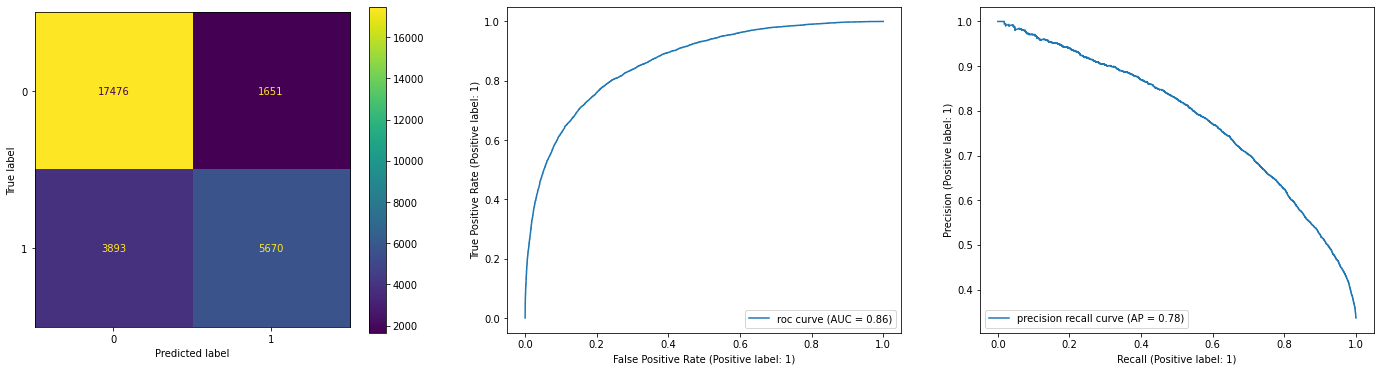

In [ ]:
print_model(model10, X_test3, y_test3)

**Model 11:** XGBoost

In [ ]:
model11 = xgb.XGBClassifier(random_state=42, max_depth=10)

In [ ]:
model11.fit(X_train3, y_train3)

XGBClassifier(max_depth=10, random_state=42)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     19127
           1       0.77      0.65      0.70      9563

    accuracy                           0.82     28690
   macro avg       0.80      0.78      0.79     28690
weighted avg       0.81      0.82      0.81     28690

cohen kappa score 0.5747935830118066


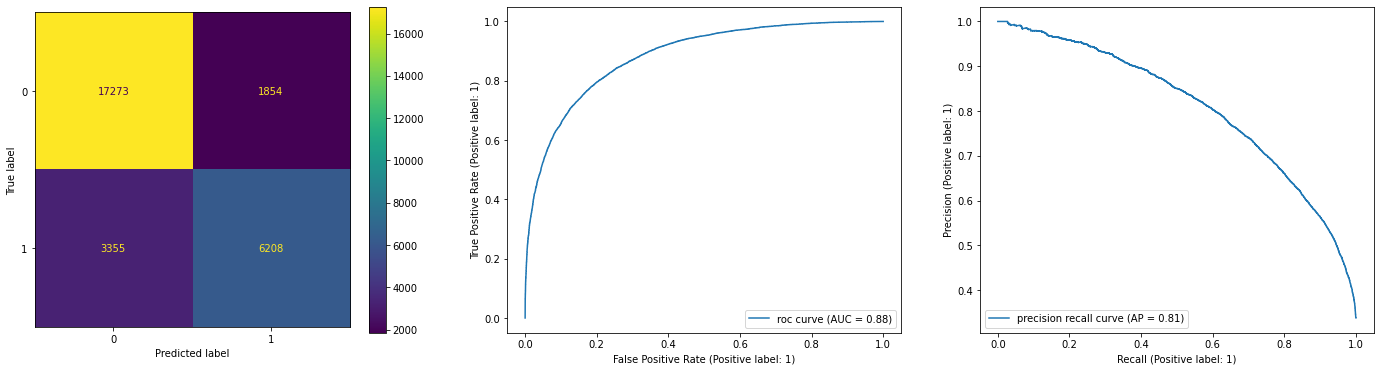

In [ ]:
print_model(model11, X_test3, y_test3)

**Over sampling using SMOTE**

In [ ]:
smote = SMOTE(random_state=42, n_jobs=-1,k_neighbors=10,  sampling_strategy=0.5)

In [ ]:
X4,y4 = smote.fit_resample(X1, y)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4,y4, random_state=42, stratify=y4, test_size=0.3) 

In [ ]:
pd.Series(y4).value_counts()

0    110316
1     55158
Name: RainTomorrow, dtype: int64

**Model 12:** XGBoost (Oversampling)

In [ ]:
model12 = xgb.XGBClassifier(random_state=42, max_depth=10,)
model12.fit(X_train4, y_train4)

XGBClassifier(max_depth=10, random_state=42)

              precision    recall  f1-score   support

           0       0.88      0.94      0.90     33095
           1       0.85      0.73      0.79     16548

    accuracy                           0.87     49643
   macro avg       0.86      0.83      0.85     49643
weighted avg       0.87      0.87      0.87     49643

cohen kappa score 0.6930755391459069


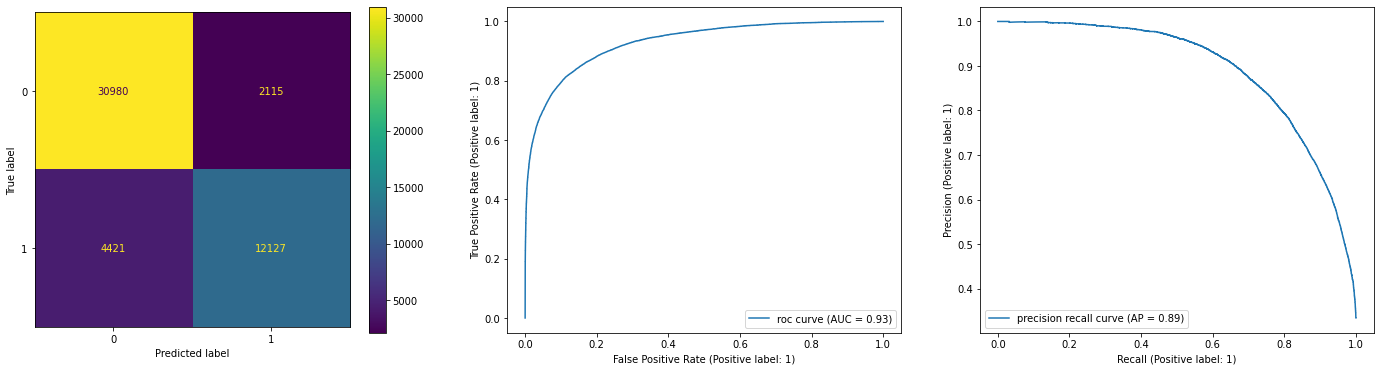

In [ ]:
print_model(model12, X_test4, y_test4)

**Model 13:** CatBoost

In [ ]:
model13 = cb.CatBoostClassifier(learning_rate=0.1, max_depth=10, random_seed=42)
model13.fit(X_train4, y_train4)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     33095
           1       0.86      0.75      0.80     16548

    accuracy                           0.88     49643
   macro avg       0.87      0.85      0.86     49643
weighted avg       0.88      0.88      0.87     49643

cohen kappa score 0.7132795292046854


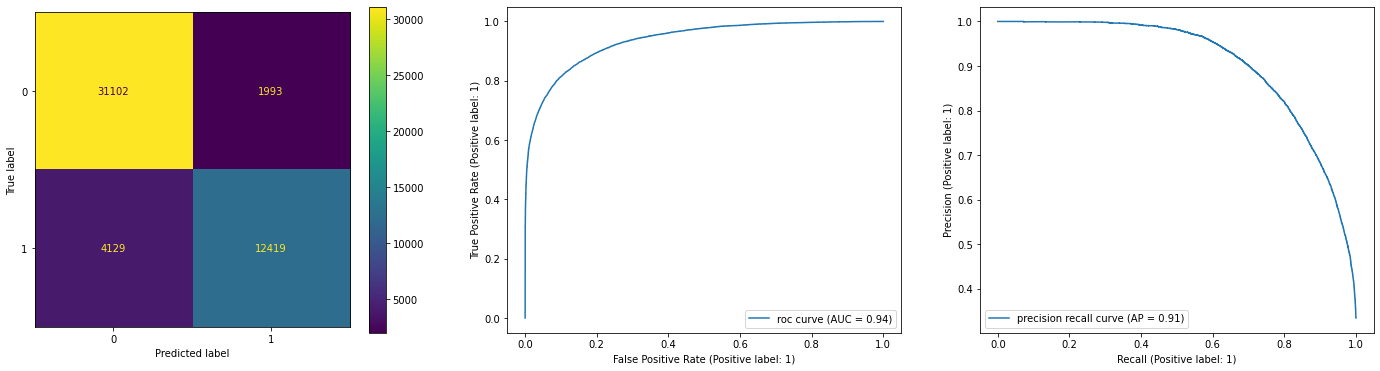

In [ ]:
print_model(model13, X_test4, y_test4)

**Models using TensorFlow**

In [ ]:
transform3 = make_column_transformer(
  (
    IterativeImputer(random_state=42),
    numerical
  ),
  (
    SimpleImputer(strategy='most_frequent'),
    categorical
  )
)
transform3

ColumnTransformer(transformers=[('iterativeimputer',
                                 IterativeImputer(random_state=42),
                                 ['MinTemp', 'MaxTemp', 'Rainfall',
                                  'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
                                  'Pressure9am', 'Pressure3pm']),
                                ('simpleimputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['Location', 'RainToday', 'Month',
                                  'WindGustDir'])])

In [ ]:
X5 = transform3.fit_transform(X,y)
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5,y, random_state=42, stratify=y, test_size=0.3)

In [ ]:
traindf1 = pd.DataFrame(X_train5, columns=[*numerical, *categorical])
traindf1['RainTomorrow'] = y_train5.values
traindf1.head(3)

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Location,RainToday,Month,WindGustDir,RainTomorrow
0,10.6,24.9,0,20,68,47,1020.58,1017.13,Penrith,No,5,NW,0
1,6,15.1,1.6,41,94,77,1023,1024,Dartmoor,Yes,9,NW,0
2,24.6,41.4,0,31,51,24,1012.7,1009.6,Moree,No,1,NE,0


In [ ]:
testdf1 = pd.DataFrame(X_test5, columns=[*numerical, *categorical])
testdf1['RainTomorrow'] = y_test5.values
testdf1.head(3)

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Location,RainToday,Month,WindGustDir,RainTomorrow
0,19.8,27.9,0,41,56,48,1007.7,1007.1,Bendigo,No,12,WNW,1
1,18.5,24,0.8,39,81,72,1015.5,1016.5,Sydney,No,1,S,0
2,9.4,21.2,0,28,64,23,1024.5,1023.1,Richmond,No,5,SW,0


In [ ]:
train_ds1 = tfdf.keras.pd_dataframe_to_tf_dataset(traindf1, label="RainTomorrow")
test_ds1 = tfdf.keras.pd_dataframe_to_tf_dataset(testdf1, label="RainTomorrow")

In [ ]:
metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]

In [ ]:
tmodel2 = tfdf.keras.RandomForestModel(tfdf.keras.Task.CLASSIFICATION)
tmodel2.compile(metrics=metrics)

In [ ]:
tmodel2.fit(train_ds1)

1556/1556 [==============================] - 8s 1ms/step


In [ ]:
tfdf.model_plotter.plot_model_in_colab(tmodel2, tree_idx=0)

In [ ]:
tmodel2.evaluate(test_ds1)

667/667 [==============================] - 16s 15ms/step - loss: 0.0000e+00 - accuracy: 0.8555 - auc: 0.8861 - precision: 0.7962 - recall: 0.4779


[0.0,
 0.8555253148078918,
 0.8861168026924133,
 0.7962315082550049,
 0.47792425751686096]

In [ ]:
tmodel2.evaluate(train_ds1)

1556/1556 [==============================] - 24s 15ms/step - loss: 0.0000e+00 - accuracy: 0.9249 - auc: 0.9354 - precision: 0.8861 - recall: 0.5772


[0.0,
 0.9249007701873779,
 0.9354099631309509,
 0.8861064910888672,
 0.5772326588630676]

In [ ]:
tmodel3 = tfdf.keras.CartModel(tfdf.keras.Task.CLASSIFICATION)
tmodel3.compile(metrics=metrics)
tmodel3.fit(train_ds1)
tmodel3.evaluate(test_ds1)

667/667 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8369 - auc: 0.9438 - precision: 0.8969 - recall: 0.6048


[0.0,
 0.8369356393814087,
 0.9437819719314575,
 0.8969441056251526,
 0.6047874093055725]

In [ ]:
tmodel3.evaluate(train_ds1)

1556/1556 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8640 - auc: 0.9216 - precision: 0.8548 - recall: 0.5788


[0.0,
 0.8639875650405884,
 0.9216409921646118,
 0.8547830581665039,
 0.5788179039955139]

In [ ]:
tmodel4 = tfdf.keras.GradientBoostedTreesModel(tfdf.keras.Task.CLASSIFICATION)
tmodel4.compile(metrics=metrics)
tmodel4.fit(train_ds1)
tmodel4.evaluate(test_ds1)

667/667 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8617 - auc: 0.9120 - precision: 0.8358 - recall: 0.5714


[0.0,
 0.8616906404495239,
 0.9119688868522644,
 0.8357933759689331,
 0.5714343190193176]

In [ ]:
tmodel4.evaluate(train_ds1)

1556/1556 [==============================] - 5s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8847 - auc: 0.9122 - precision: 0.8297 - recall: 0.5758


[0.0,
 0.8846637010574341,
 0.9122108817100525,
 0.8296853303909302,
 0.5757806897163391]

In [ ]:
smote1 = SMOTENC(random_state=42, n_jobs=-1,k_neighbors=10,  sampling_strategy=0.5, categorical_features=[11,10,9,8])

In [ ]:
categorical

['Location', 'RainToday', 'Month', 'WindGustDir']

In [ ]:
transform4 = make_column_transformer(
  (
    IterativeImputer(random_state=42),
    numerical
  ),
  (
    SimpleImputer(strategy='most_frequent'),
    categorical
  )
)
transform4

ColumnTransformer(transformers=[('iterativeimputer',
                                 IterativeImputer(random_state=42),
                                 ['MinTemp', 'MaxTemp', 'Rainfall',
                                  'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
                                  'Pressure9am', 'Pressure3pm']),
                                ('simpleimputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['Location', 'RainToday', 'Month',
                                  'WindGustDir'])])

In [ ]:
X6 = transform4.fit_transform(X,y)

In [ ]:
X6,y6 = smote1.fit_resample(X6, y)
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6,y6, random_state=42, stratify=y6, test_size=0.3)

In [ ]:
traindf2 = pd.DataFrame(X_train6, columns=[*numerical, *categorical])
traindf2['RainTomorrow'] = y_train6.values
testdf2 = pd.DataFrame(X_test6, columns=[*numerical, *categorical])
testdf2['RainTomorrow'] = y_test6.values
train_ds2 = tfdf.keras.pd_dataframe_to_tf_dataset(traindf2, label="RainTomorrow")
test_ds2 = tfdf.keras.pd_dataframe_to_tf_dataset(testdf2, label="RainTomorrow")

In [ ]:
tmodel5 = tfdf.keras.GradientBoostedTreesModel(tfdf.keras.Task.CLASSIFICATION)
tmodel5.compile(metrics=metrics)
tmodel5.fit(train_ds2)
tmodel5.evaluate(test_ds2)

1810/1810 [==============================] - 3s 2ms/step


776/776 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8625 - auc: 0.9147 - precision: 0.8300 - recall: 0.5923


[0.0,
 0.8624579310417175,
 0.9147052764892578,
 0.8300090432167053,
 0.5922614336013794]

In [ ]:
tmodel6 = tfdf.keras.CartModel(tfdf.keras.Task.CLASSIFICATION)
tmodel6.compile(metrics=metrics)
tmodel6.fit(train_ds2)
tmodel6.evaluate(test_ds2)

1810/1810 [==============================] - 3s 1ms/step


776/776 [==============================] - 3s 2ms/step - loss: 0.0000e+00 - accuracy: 0.8129 - auc: 0.9128 - precision: 0.8244 - recall: 0.6062


[0.0,
 0.8129041194915771,
 0.912834644317627,
 0.8244314193725586,
 0.6061575412750244]

In [ ]:
tmodel7 = tfdf.keras.RandomForestModel(tfdf.keras.Task.CLASSIFICATION)
tmodel7.compile(metrics=metrics)
tmodel7.fit(train_ds2)
tmodel7.evaluate(test_ds2)

776/776 [==============================] - 18s 22ms/step - loss: 0.0000e+00 - accuracy: 0.8441 - auc: 0.9104 - precision: 0.8192 - recall: 0.6132


[0.0,
 0.844106912612915,
 0.9103876352310181,
 0.8191526532173157,
 0.613230288028717]

**Model Comparison:**

In [ ]:
all_models = {
    'Logistic': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(random_state=42, n_estimators=100),
    'GradientBoost': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'BaggingClassifier': BaggingClassifier(LogisticRegression(), n_estimators=20, n_jobs=-1, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, max_depth=10),
    'CatBoost': cb.CatBoostClassifier(learning_rate=0.1, max_depth=10, random_seed=42),
}
datasets = {
    'None': {
        'x_train': X_train1,
        'x_test': X_test1,
        'y_train': y_train1,
        'y_test': y_test1,
    },
    'Under': {
        'x_train': X_train3,
        'x_test': X_test3,
        'y_train': y_train3,
        'y_test': y_test3,
    },
    'Over': {
        'x_train': X_train4,
        'x_test': X_test4,
        'y_train': y_train4,
        'y_test': y_test4,
    }
}
def get_metrics(models, datasets):
  metrics = {
    'model': [],
    'sampling': [],
    'tr_f1': [],
    'ts_f1': [],
    'tr_0_prec': [],
    'ts_0_prec': [],
    'tr_0_recall': [],
    'ts_0_recall': [],
    'tr_0_f1' : [],
    'ts_0_f1' : [],
    'tr_1_prec': [],
    'ts_1_prec': [],
    'tr_1_recall': [],
    'ts_1_recall': [],
    'tr_1_f1' : [],
    'ts_1_f1' : [],
    'tr_cohen':[],
    'ts_cohen':[],
  }
  for sampling in datasets.keys():
    obj = datasets[sampling]
    for key in models.keys():
      model = clone(models[key])
      model.fit(obj['x_train'], obj['y_train'])
      ytpred = model.predict(obj['x_train'])
      ypred = model.predict(obj['x_test'])
      report_train = classification_report(obj['y_train'], ytpred, output_dict=True)
      report_test = classification_report(obj['y_test'], ypred, output_dict=True)
      metrics['model'].append(key)
      metrics['sampling'].append(sampling)
      metrics['tr_cohen'].append(cohen_kappa_score(obj['y_train'], ytpred))
      metrics['ts_cohen'].append(cohen_kappa_score(obj['y_test'], ypred))
      metrics['tr_0_f1'].append(report_train['0']['f1-score'])
      metrics['tr_0_prec'].append(report_train['0']['precision'])
      metrics['tr_0_recall'].append(report_train['0']['recall'])
      metrics['tr_1_f1'].append(report_train['1']['f1-score'])
      metrics['tr_1_prec'].append(report_train['1']['precision'])
      metrics['tr_1_recall'].append(report_train['1']['recall'])
      metrics['tr_f1'].append(report_train['accuracy'])
      metrics['ts_0_f1'].append(report_test['0']['f1-score'])
      metrics['ts_0_prec'].append(report_test['0']['precision'])
      metrics['ts_0_recall'].append(report_test['0']['recall'])
      metrics['ts_1_f1'].append(report_test['1']['f1-score'])
      metrics['ts_1_prec'].append(report_test['1']['precision'])
      metrics['ts_1_recall'].append(report_test['1']['recall'])
      metrics['ts_f1'].append(report_test['accuracy'])
  
  return pd.DataFrame(metrics)

In [ ]:
t_datasets = {
    'None': {
        'x_train': train_ds1,
        'x_test': test_ds1,
        'y_train': traindf1['RainTomorrow'].values,
        'y_test': testdf1['RainTomorrow'].values,
        'models': {
          'T CART': tfdf.keras.CartModel(tfdf.keras.Task.CLASSIFICATION),
          'T RandomForest': tfdf.keras.RandomForestModel(tfdf.keras.Task.CLASSIFICATION),
          'T GradientBoost': tfdf.keras.GradientBoostedTreesModel(tfdf.keras.Task.CLASSIFICATION),
        },
    },
    'Over': {
        'x_train': train_ds2,
        'x_test': test_ds2,
        'y_train': traindf2['RainTomorrow'].values,
        'y_test': testdf2['RainTomorrow'].values,
        'models': {
          'T CART': tfdf.keras.CartModel(tfdf.keras.Task.CLASSIFICATION),
          'T RandomForest': tfdf.keras.RandomForestModel(tfdf.keras.Task.CLASSIFICATION),
          'T GradientBoost': tfdf.keras.GradientBoostedTreesModel(tfdf.keras.Task.CLASSIFICATION),
        },
    }
}
t_metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
def get_t_metrics(datasets):
  metrics = {
    'model': [],
    'sampling': [],
    'tr_f1': [],
    'ts_f1': [],
    'tr_0_prec': [],
    'ts_0_prec': [],
    'tr_0_recall': [],
    'ts_0_recall': [],
    'tr_0_f1' : [],
    'ts_0_f1' : [],
    'tr_1_prec': [],
    'ts_1_prec': [],
    'tr_1_recall': [],
    'ts_1_recall': [],
    'tr_1_f1' : [],
    'ts_1_f1' : [],
    'tr_cohen':[],
    'ts_cohen':[],
  }
  for sampling in datasets.keys():
    obj = datasets[sampling]
    models = obj['models']
    for key in models.keys():
      model = models[key]
      model.compile(metrics=t_metrics)
      model.fit(obj['x_train'])
      ytpred = model.predict(obj['x_train'])
      ytpred = list(map(int,(ytpred.reshape(-1,) > 0.5)))
      ypred = model.predict(obj['x_test'])
      ypred = list(map(int,(ypred.reshape(-1,) > 0.5)))
      y_train = obj['y_train']
      y_test = obj['y_test']
      report_train = classification_report(y_train, ytpred, output_dict=True)
      report_test = classification_report(y_test, ypred, output_dict=True)
      metrics['model'].append(key)
      metrics['sampling'].append(sampling)
      metrics['tr_cohen'].append(cohen_kappa_score(y_train, ytpred))
      metrics['ts_cohen'].append(cohen_kappa_score(y_test, ypred))
      metrics['tr_0_f1'].append(report_train['0']['f1-score'])
      metrics['tr_0_prec'].append(report_train['0']['precision'])
      metrics['tr_0_recall'].append(report_train['0']['recall'])
      metrics['tr_1_f1'].append(report_train['1']['f1-score'])
      metrics['tr_1_prec'].append(report_train['1']['precision'])
      metrics['tr_1_recall'].append(report_train['1']['recall'])
      metrics['tr_f1'].append(report_train['accuracy'])
      metrics['ts_0_f1'].append(report_test['0']['f1-score'])
      metrics['ts_0_prec'].append(report_test['0']['precision'])
      metrics['ts_0_recall'].append(report_test['0']['recall'])
      metrics['ts_1_f1'].append(report_test['1']['f1-score'])
      metrics['ts_1_prec'].append(report_test['1']['precision'])
      metrics['ts_1_recall'].append(report_test['1']['recall'])
      metrics['ts_f1'].append(report_test['accuracy'])
  
  return pd.DataFrame(metrics)

In [ ]:
t_results = get_t_metrics(t_datasets)

1810/1810 [==============================] - 3s 2ms/step


In [ ]:
t_results

,model,sampling,tr_f1,ts_f1,tr_0_prec,ts_0_prec,tr_0_recall,ts_0_recall,tr_0_f1,ts_0_f1,tr_1_prec,ts_1_prec,tr_1_recall,ts_1_recall,tr_1_f1,ts_1_f1,tr_cohen,ts_cohen
0,T CART,None,0.863988,0.836936,0.878448,0.861186,0.957123,0.941592,0.916100,0.899596,0.784972,0.701375,0.541678,0.474746,0.641016,0.566226,0.560570,0.470374
1,T RandomForest,None,0.924901,0.855525,0.915997,0.865170,0.994393,0.964013,0.953586,0.911921,0.972429,0.794016,0.684413,0.480079,0.803388,0.598371,0.758695,0.516726
2,T GradientBoost,None,0.884664,0.861691,0.896283,0.881641,0.962743,0.949146,0.928325,0.914149,0.826561,0.760563,0.614457,0.559030,0.704899,0.644407,0.635145,0.561028
3,T CART,Over,0.847554,0.812904,0.864010,0.838581,0.915412,0.890829,0.888969,0.863916,0.807973,0.750587,0.711836,0.657058,0.756864,0.700715,0.646478,0.565504
4,T RandomForest,Over,0.919158,0.844107,0.909977,0.849931,0.975214,0.930443,0.941467,0.888366,0.942130,0.828375,0.807045,0.671441,0.869371,0.741698,0.811342,0.631806
5,T GradientBoost,Over,0.883477,0.862458,0.890609,0.872550,0.940767,0.929446,0.915001,0.900099,0.866495,0.837735,0.768894,0.728487,0.814782,0.779301,0.730225,0.680105


**Model Selection:**

In [ ]:
results = get_metrics(all_models, datasets)

In [ ]:
all_results = results.append(t_results).reset_index(drop=True)

In [ ]:
all_results.sort_values(by=['ts_f1'], ascending=False)

,model,sampling,tr_f1,ts_f1,tr_0_prec,ts_0_prec,tr_0_recall,ts_0_recall,tr_0_f1,ts_0_f1,tr_1_prec,ts_1_prec,tr_1_recall,ts_1_recall,tr_1_f1,ts_1_f1,tr_cohen,ts_cohen
23,CatBoost,Over,0.960503,0.876679,0.951262,0.882802,0.991557,0.939779,0.970992,0.910400,0.981550,0.861712,0.898394,0.750483,0.938133,0.802261,0.909208,0.713280
22,XGBoost,Over,0.905647,0.868340,0.903344,0.875117,0.961332,0.936093,0.931436,0.904578,0.911271,0.851496,0.794276,0.732838,0.848761,0.787723,0.780665,0.693076
29,T GradientBoost,Over,0.883477,0.862458,0.890609,0.872550,0.940767,0.929446,0.915001,0.900099,0.866495,0.837735,0.768894,0.728487,0.814782,0.779301,0.730225,0.680105
26,T GradientBoost,None,0.884664,0.861691,0.896283,0.881641,0.962743,0.949146,0.928325,0.914149,0.826561,0.760563,0.614457,0.559030,0.704899,0.644407,0.635145,0.561028
7,CatBoost,None,0.961682,0.859722,0.955712,0.881362,0.996801,0.946608,0.975824,0.912821,0.986996,0.751582,0.840145,0.559030,0.907669,0.641161,0.883690,0.556308
6,XGBoost,None,0.910122,0.858456,0.911906,0.877332,0.978698,0.950446,0.944122,0.912427,0.901249,0.759001,0.672806,0.540102,0.770451,0.631109,0.716028,0.546592
25,T RandomForest,None,0.924901,0.855525,0.915997,0.865170,0.994393,0.964013,0.953586,0.911921,0.972429,0.794016,0.684413,0.480079,0.803388,0.598371,0.758695,0.516726
4,GradientBoost,None,0.850244,0.848868,0.866960,0.866527,0.953251,0.951805,0.908060,0.907167,0.753213,0.747066,0.493771,0.492628,0.596503,0.593736,0.509402,0.505661
5,BaggingClassifier,None,0.845843,0.847274,0.867253,0.867533,0.946116,0.947877,0.904970,0.905927,0.727897,0.734534,0.498835,0.499111,0.591980,0.594359,0.501002,0.504471
0,Logistic,None,0.846034,0.847227,0.867205,0.867424,0.946478,0.947968,0.905109,0.905909,0.729072,0.734669,0.498431,0.498588,0.592084,0.594032,0.501289,0.504153


**Observation:** From the above table, we infer that CatBoost model gives us the best prediction and has been selected for model deployment.

**Model Deployment:**

In [ ]:
import joblib

In [ ]:
joblib.dump(transform1, "rainfall_transformer.m5")
joblib.dump(model13, "rainfall.m5")

['rainfall.m5']

**References:**

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html 

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5 

https://blog.tensorflow.org/2021/05/introducing-tensorflow-decision-forests.html